**This Notebook contains two tasks**

*(Custom models with accuracy more than 85% and transfer learning)*

**Importing libraries**

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from google.colab import files
from zipfile import ZipFile
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import InceptionResNetV2

**Loading the data**

In [89]:
# !pip install kaggle

In [90]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"invalidcoder","key":"1dd1a92dbc83806575b9cbd7a17f98a2"}'}

In [91]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [92]:
# !kaggle datasets download -d omkargurav/face-mask-dataset

face-mask-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [93]:
file_name = 'face-mask-dataset.zip'

with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print("Done")

Done


In [94]:
batch_size = 40
img_height = 200
img_width = 200

In [95]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 7553 files belonging to 2 classes.
Using 6043 files for training.


In [96]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


In [97]:
class_names = train_data.class_names

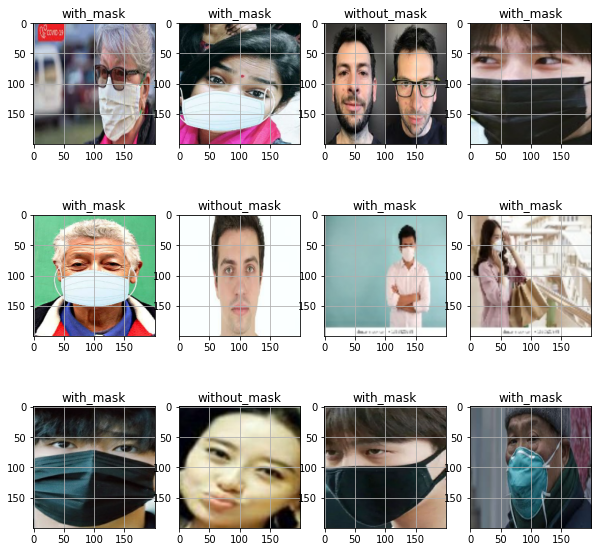

In [98]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.grid(True)

**Configuring datasets for performance**

In [99]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

**Modeling**

Using flatten layer will increase the size of the model,

hence use Global avg Pooling instead.

Is it necessary to include input_shape in the first layer? (input_shape=(200,200,3))

Does it affect the performance?

In [100]:
model = tf.keras.models.Sequential([
    layers.experimental.preprocessing.Rescaling(1. / 255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [101]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

**Training my CNN**

In [102]:
retVal = model.fit(train_data, validation_data=test_data, epochs=15)

Epoch 1/15
152/152 [==============================] - 15s 93ms/step - loss: 0.6362 - accuracy: 0.6317 - val_loss: 0.5316 - val_accuracy: 0.7517
Epoch 2/15
152/152 [==============================] - 7s 44ms/step - loss: 0.5300 - accuracy: 0.7421 - val_loss: 0.5308 - val_accuracy: 0.7285
Epoch 3/15
152/152 [==============================] - 7s 44ms/step - loss: 0.5133 - accuracy: 0.7535 - val_loss: 0.4690 - val_accuracy: 0.7821
Epoch 4/15
152/152 [==============================] - 7s 44ms/step - loss: 0.4743 - accuracy: 0.7763 - val_loss: 0.4226 - val_accuracy: 0.7974
Epoch 5/15
152/152 [==============================] - 7s 44ms/step - loss: 0.4134 - accuracy: 0.8193 - val_loss: 0.3584 - val_accuracy: 0.8437
Epoch 6/15
152/152 [==============================] - 7s 44ms/step - loss: 0.3580 - accuracy: 0.8561 - val_loss: 0.2979 - val_accuracy: 0.8762
Epoch 7/15
152/152 [==============================] - 7s 44ms/step - loss: 0.3252 - accuracy: 0.8679 - val_loss: 0.2766 - val_accuracy: 0.888

**Let's visualize the result of training.**

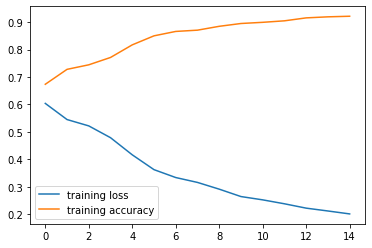

In [103]:
plt.plot(retVal.history['loss'], label='training loss')
plt.plot(retVal.history['accuracy'], label='training accuracy')
plt.legend()

Is it bad when the learning curve looks almost like a line?

Let's match the predicted labels with  real images.

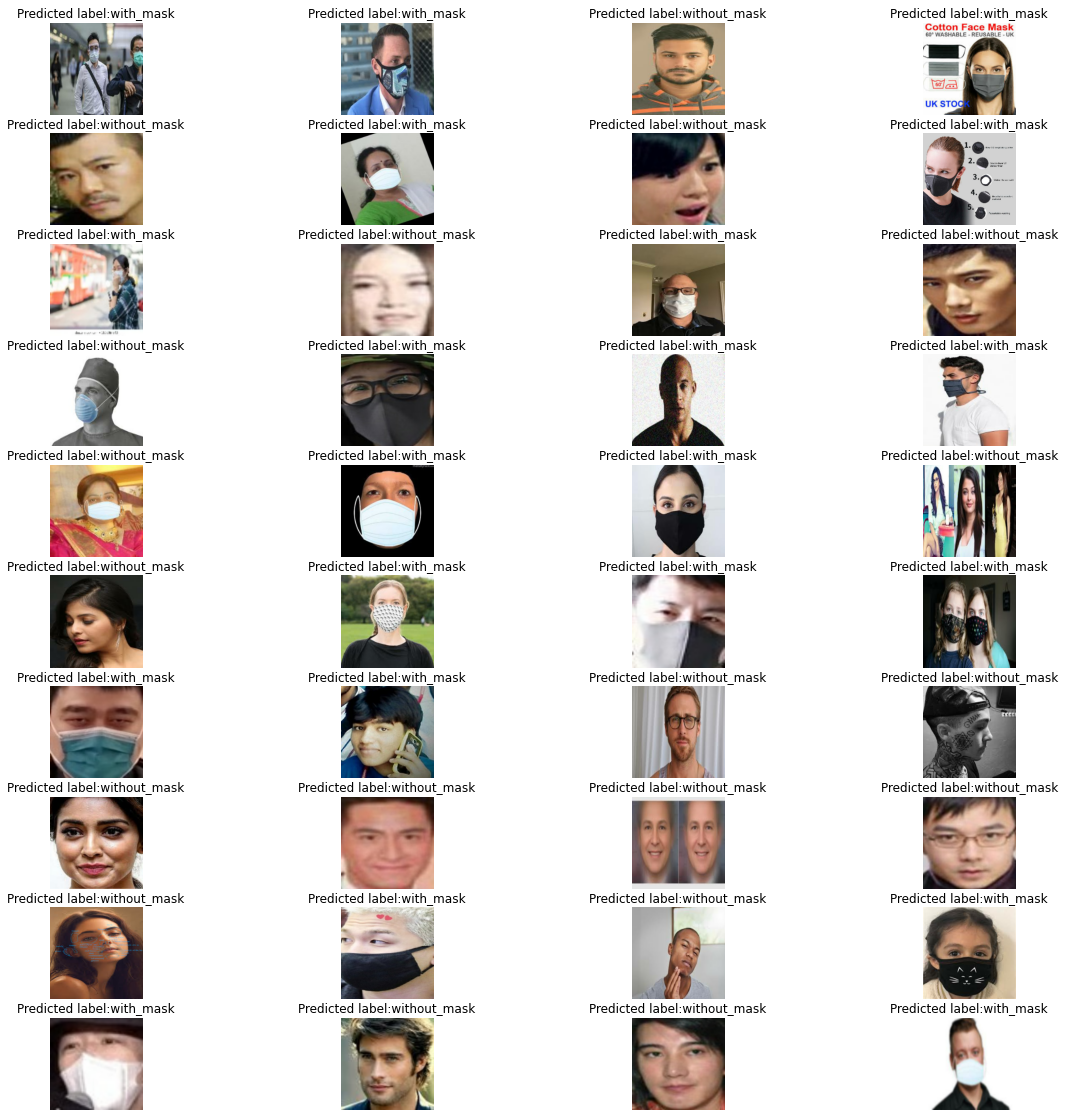

In [104]:
plt.figure(figsize=(20, 20))
for images, labels in test_data.take(1):
    predictions = model.predict(images)
    predlabel = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])

    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:' + predlabel[i])
        plt.axis('off')
        plt.grid(True)

Checking for scores.

In [105]:
scores = model.evaluate(test_data, verbose=0)
print(scores[1] * 100)

93.17880868911743


**Experimenting with different structures of model**

In this one flatten was used.

In [106]:
model_1 = tf.keras.models.Sequential([
    layers.experimental.preprocessing.Rescaling(1. / 255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),     
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')                                
])

In [107]:
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

**Training the model.**

In [108]:
retVal_1 = model_1.fit(train_data, validation_data=test_data, epochs=15)

Epoch 1/15
152/152 [==============================] - 19s 121ms/step - loss: 1.8835 - accuracy: 0.7273 - val_loss: 0.2550 - val_accuracy: 0.8901
Epoch 2/15
152/152 [==============================] - 18s 120ms/step - loss: 0.2731 - accuracy: 0.8849 - val_loss: 0.2358 - val_accuracy: 0.8947
Epoch 3/15
152/152 [==============================] - 18s 121ms/step - loss: 0.2369 - accuracy: 0.9039 - val_loss: 0.2192 - val_accuracy: 0.9086
Epoch 4/15
152/152 [==============================] - 18s 121ms/step - loss: 0.2250 - accuracy: 0.9079 - val_loss: 0.2248 - val_accuracy: 0.9066
Epoch 5/15
152/152 [==============================] - 18s 121ms/step - loss: 0.2063 - accuracy: 0.9125 - val_loss: 0.1825 - val_accuracy: 0.9272
Epoch 6/15
152/152 [==============================] - 18s 120ms/step - loss: 0.1786 - accuracy: 0.9272 - val_loss: 0.1800 - val_accuracy: 0.9285
Epoch 7/15
152/152 [==============================] - 18s 120ms/step - loss: 0.1553 - accuracy: 0.9373 - val_loss: 0.1607 - val_ac

It took me a little bit more time for training in case of using flatten which increased the size of the model.

Am i correct?

Visualizing the trainging process

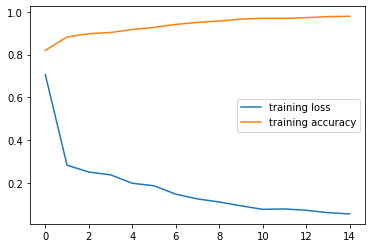

In [109]:
plt.plot(retVal_1.history['loss'], label='training loss')
plt.plot(retVal_1.history['accuracy'], label='training accuracy')
plt.legend()

I think this curves look better than previous ones, aren't them?

Let's match the predicted labels with real images.

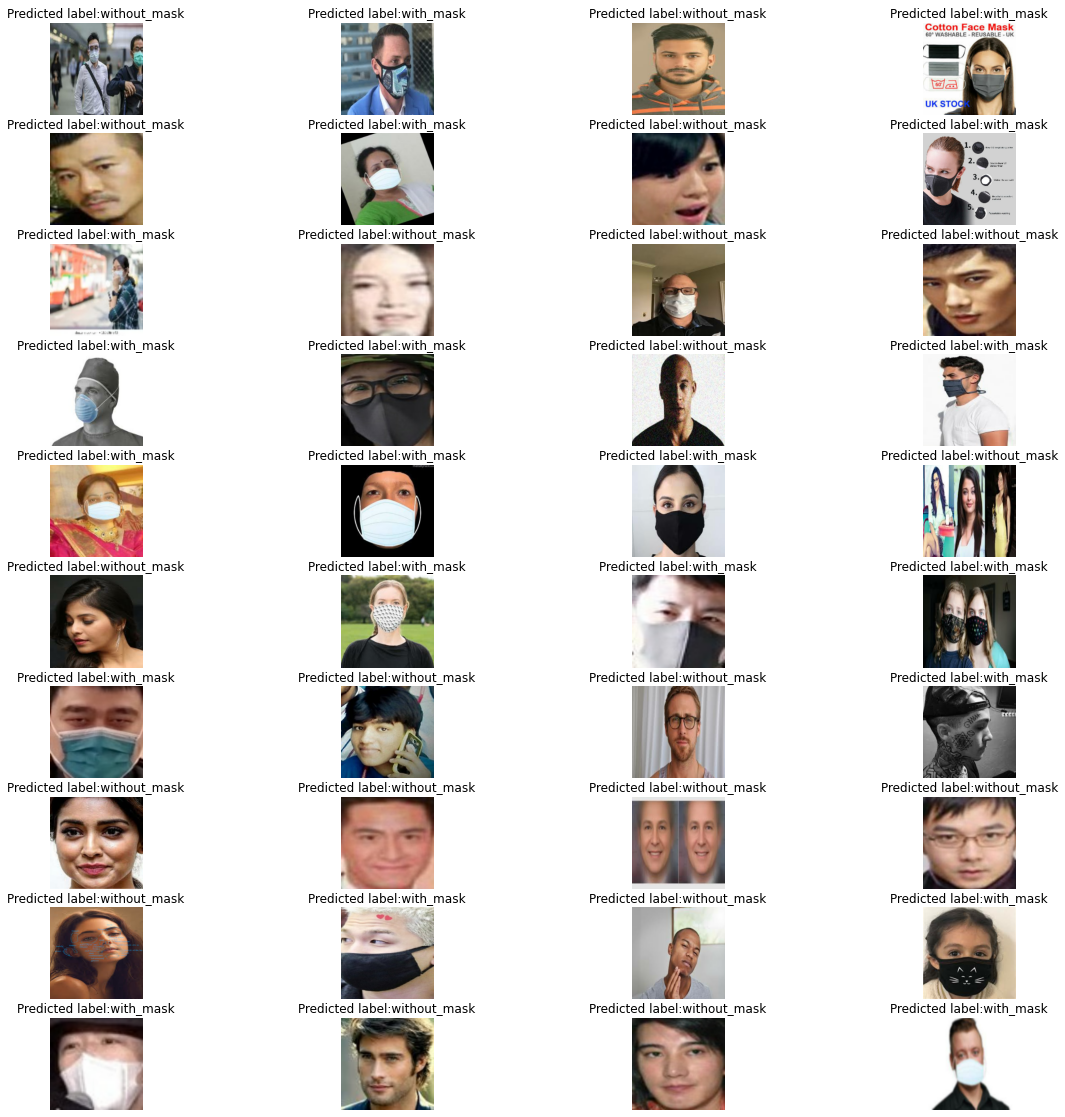

In [110]:
plt.figure(figsize=(20, 20))
for images, labels in test_data.take(1):
    predictions = model_1.predict(images)
    predlabel = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])

    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:' + predlabel[i])
        plt.axis('off')
        plt.grid(True)

In [111]:
scores = model_1.evaluate(test_data, verbose=0)
print(scores[1] * 100)

93.64238381385803


The last custom model with 3 layers of convolutions and subsamplings

In [112]:
model_2 = tf.keras.models.Sequential([
    layers.experimental.preprocessing.Rescaling(1. / 255),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')                                
])

In [113]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [114]:
retVal_2 = model_2.fit(train_data, validation_data=test_data, epochs=15)

Epoch 1/15
152/152 [==============================] - 6s 35ms/step - loss: 0.5730 - accuracy: 0.7053 - val_loss: 0.2586 - val_accuracy: 0.8927
Epoch 2/15
152/152 [==============================] - 5s 34ms/step - loss: 0.2719 - accuracy: 0.8903 - val_loss: 0.2194 - val_accuracy: 0.9119
Epoch 3/15
152/152 [==============================] - 5s 34ms/step - loss: 0.2356 - accuracy: 0.9044 - val_loss: 0.1912 - val_accuracy: 0.9179
Epoch 4/15
152/152 [==============================] - 5s 34ms/step - loss: 0.2285 - accuracy: 0.9136 - val_loss: 0.1864 - val_accuracy: 0.9291
Epoch 5/15
152/152 [==============================] - 5s 34ms/step - loss: 0.2111 - accuracy: 0.9166 - val_loss: 0.1597 - val_accuracy: 0.9351
Epoch 6/15
152/152 [==============================] - 5s 34ms/step - loss: 0.1741 - accuracy: 0.9332 - val_loss: 0.1496 - val_accuracy: 0.9371
Epoch 7/15
152/152 [==============================] - 5s 34ms/step - loss: 0.1604 - accuracy: 0.9326 - val_loss: 0.1452 - val_accuracy: 0.9457

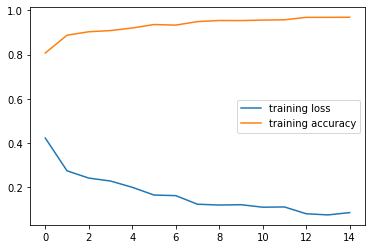

In [115]:
plt.plot(retVal_2.history['loss'], label='training loss')
plt.plot(retVal_2.history['accuracy'], label='training accuracy')
plt.legend()

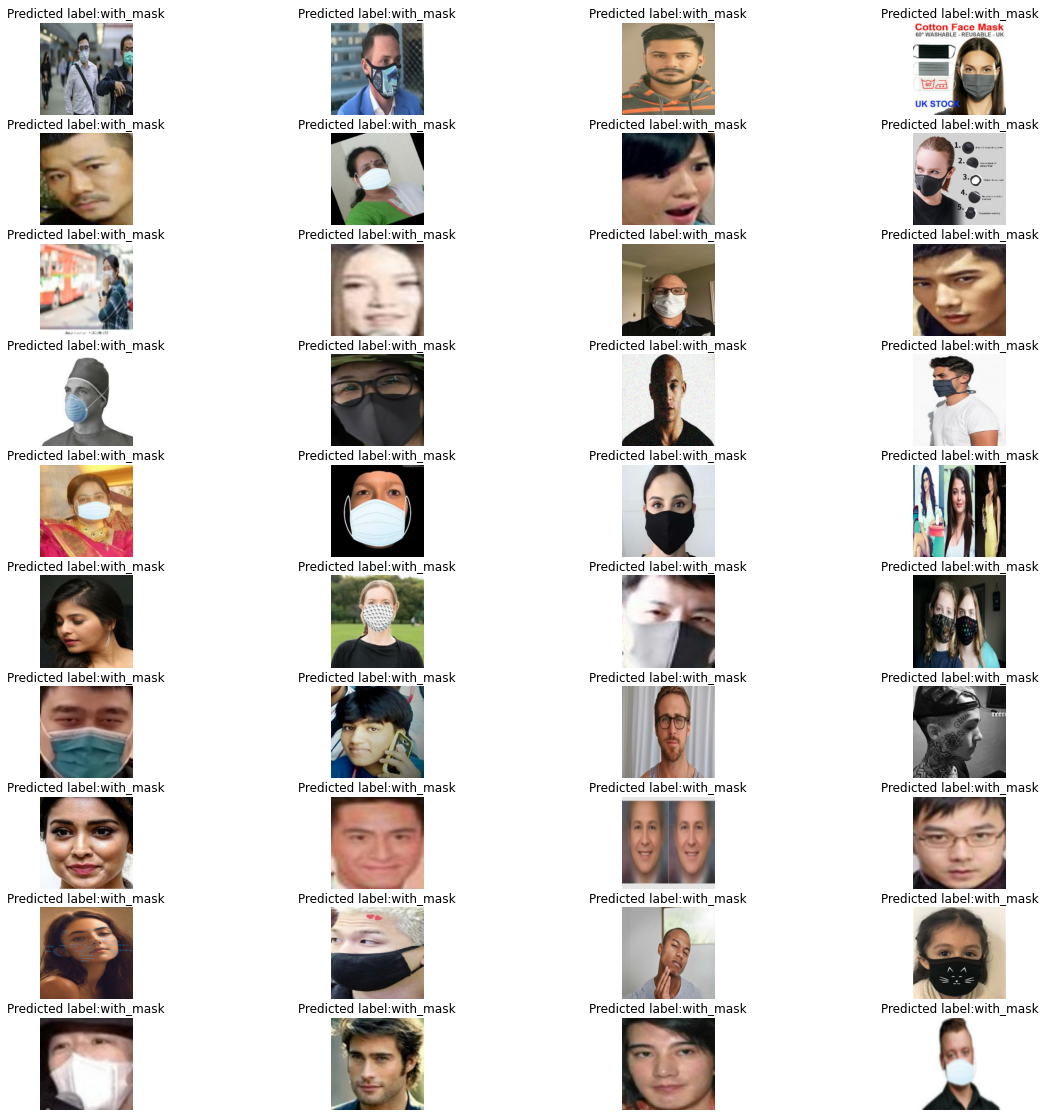

In [116]:
plt.figure(figsize=(20, 20))
for images, labels in test_data.take(1):
    predictions = model_2.predict(images)
    predlabel = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])

    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:' + predlabel[i])
        plt.axis('off')
        plt.grid(True)

In [117]:
scores = model_2.evaluate(test_data, verbose=0)
print(scores[1] * 100)

94.56953406333923


**Transfer learning**

Let's use VGG16,VGG19, Incsption v3, ResNet50, Xception CNNs.

**VGG16**

include_top=False means that won't include the part of the VGG16 that is dedicated to classification.

(Only Convolutional part will be included)

weights='imagenet' means that we want to use learnt weights from imagenet dataset.

In [118]:
VGG16_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))


trainable=False means that we don't want to teach convolutional part of the model.

In [119]:
VGG16_model.trainable = False

Let's see all layers and amount of parameters of the vgg16.

In [120]:
VGG16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

Let's create model based on vgg16

In [121]:
model_3 = tf.keras.models.Sequential([
    VGG16_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')                                
])

In [122]:
model_3.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 257       
Total params: 19,433,793
Trainable params: 4,719,105
Non-trainable params: 14,714,688
_________________________________________________________________


In terms of vgg16 had been already trained we need to set a low learing rate for convergence.


In [123]:
model_3.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

Training model. 5 epochs will be enought due to part of the model had been already trained


In [124]:
retVal_3 = model_3.fit(train_data, validation_data=test_data, epochs=5)

Epoch 1/5
152/152 [==============================] - 28s 181ms/step - loss: 3.4399 - accuracy: 0.7192 - val_loss: 0.3087 - val_accuracy: 0.9536
Epoch 2/5
152/152 [==============================] - 27s 180ms/step - loss: 0.6092 - accuracy: 0.9300 - val_loss: 0.2180 - val_accuracy: 0.9715
Epoch 3/5
152/152 [==============================] - 27s 179ms/step - loss: 0.3367 - accuracy: 0.9566 - val_loss: 0.1736 - val_accuracy: 0.9742
Epoch 4/5
152/152 [==============================] - 27s 180ms/step - loss: 0.2286 - accuracy: 0.9697 - val_loss: 0.1442 - val_accuracy: 0.9775
Epoch 5/5
152/152 [==============================] - 27s 180ms/step - loss: 0.1532 - accuracy: 0.9792 - val_loss: 0.1388 - val_accuracy: 0.9795


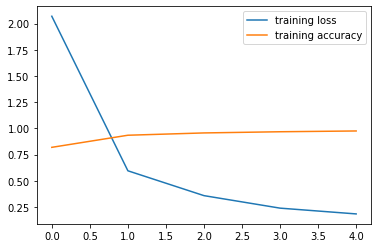

In [125]:
plt.plot(retVal_3.history['loss'], label='training loss')
plt.plot(retVal_3.history['accuracy'], label='training accuracy')
plt.legend()

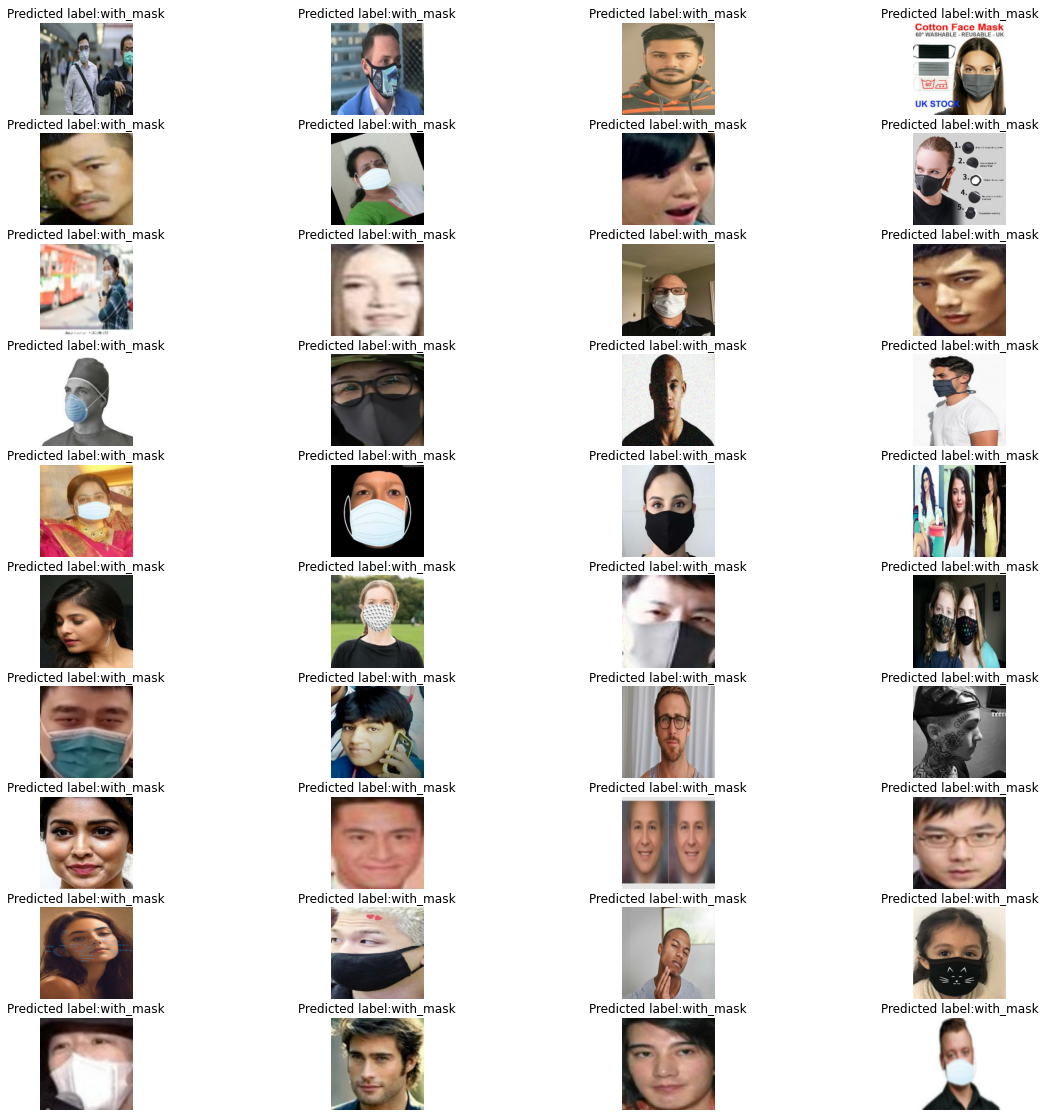

In [126]:
plt.figure(figsize=(20, 20))
for images, labels in test_data.take(1):
    predictions = model_3.predict(images)
    predlabel = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])

    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:' + predlabel[i])
        plt.axis('off')
        plt.grid(True)

In [127]:
scores = model_3.evaluate(test_data, verbose=0)
print(scores[1] * 100)

97.94701933860779


**VGG19**

In [128]:
VGG19_model = VGG19(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

trainable=False means that we don't want to teach convolutional part of the model.

In [129]:
VGG19_model.trainable = False

Let's see all layers and amount of parameters of the vgg16.

In [130]:
VGG19_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

Let's create model based on vgg19

In [131]:
model_4 = tf.keras.models.Sequential([
    VGG19_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')                                
])

In [132]:
model_4.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 6, 6, 512)         20024384  
_________________________________________________________________
flatten_10 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 257       
Total params: 24,743,489
Trainable params: 4,719,105
Non-trainable params: 20,024,384
_________________________________________________________________


In terms of vgg19 had been already trained we need to set a low learing rate for convergence.


In [133]:
model_4.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

Training model. 5 epochs will be enought due to part of the model had been already trained


In [134]:
retVal_4 = model_4.fit(train_data, validation_data=test_data, epochs=5)

Epoch 1/5
152/152 [==============================] - 34s 222ms/step - loss: 2.6843 - accuracy: 0.7554 - val_loss: 0.2160 - val_accuracy: 0.9623
Epoch 2/5
152/152 [==============================] - 33s 220ms/step - loss: 0.4532 - accuracy: 0.9391 - val_loss: 0.1310 - val_accuracy: 0.9768
Epoch 3/5
152/152 [==============================] - 33s 220ms/step - loss: 0.2523 - accuracy: 0.9653 - val_loss: 0.1171 - val_accuracy: 0.9795
Epoch 4/5
152/152 [==============================] - 33s 221ms/step - loss: 0.1608 - accuracy: 0.9690 - val_loss: 0.0929 - val_accuracy: 0.9861
Epoch 5/5
152/152 [==============================] - 33s 221ms/step - loss: 0.1489 - accuracy: 0.9782 - val_loss: 0.0954 - val_accuracy: 0.9841


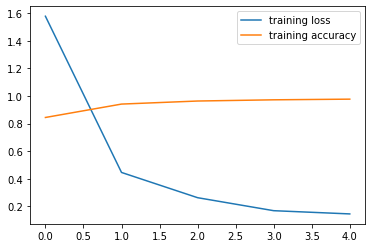

In [135]:
plt.plot(retVal_4.history['loss'], label='training loss')
plt.plot(retVal_4.history['accuracy'], label='training accuracy')
plt.legend()

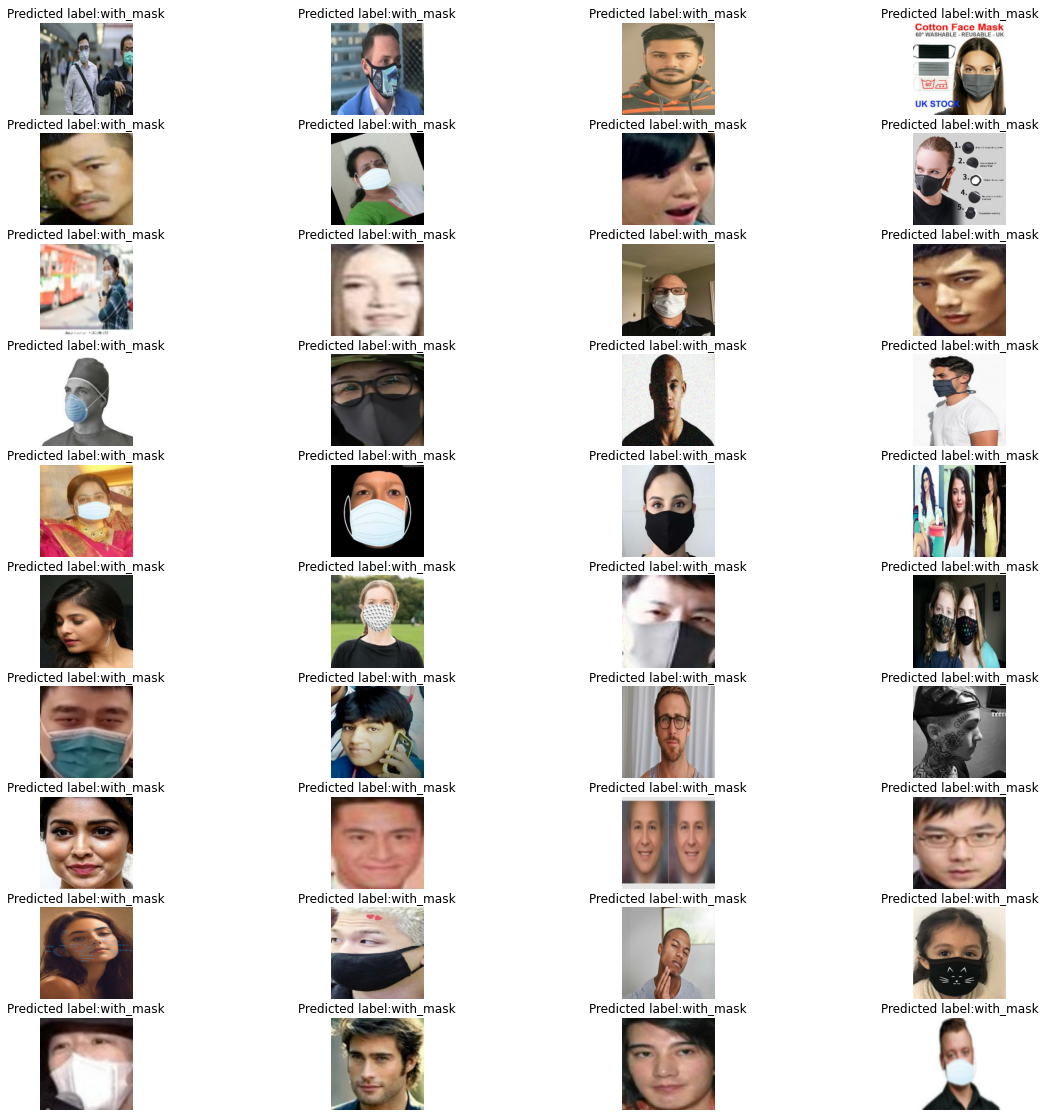

In [136]:
plt.figure(figsize=(20, 20))
for images, labels in test_data.take(1):
    predictions = model_4.predict(images)
    predlabel = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])

    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:' + predlabel[i])
        plt.axis('off')
        plt.grid(True)

In [137]:
scores = model_4.evaluate(test_data, verbose=0)
print(scores[1] * 100)

98.41059446334839


**InceptionV3**

In [138]:
incV3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

trainable=False means that we don't want to teach convolutional part of the model.

In [139]:
incV3_model.trainable = False

Let's see all layers and amount of parameters of the InceptionV3.

In [140]:
incV3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_317 (Conv2D)             (None, 99, 99, 32)   864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_297 (BatchN (None, 99, 99, 32)   96          conv2d_317[0][0]                 
__________________________________________________________________________________________________
activation_297 (Activation)     (None, 99, 99, 32)   0           batch_normalization_297[0][0]    
_______________________________________________________________________________________

Let's create model based on InceptionV3

In [141]:
model_5 = tf.keras.models.Sequential([
    incV3_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')                                
])

In [142]:
model_5.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
flatten_11 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               8388864   
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 257       
Total params: 30,191,905
Trainable params: 8,389,121
Non-trainable params: 21,802,784
_________________________________________________________________


In terms of InceptionV3 had been already trained we need to set a low learing rate for convergence.


In [143]:
model_5.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

Training model. 5 epochs will be enought due to part of the model had been already trained


In [144]:
retVal_5 = model_5.fit(train_data, validation_data=test_data, epochs=5)

Epoch 1/5
152/152 [==============================] - 17s 89ms/step - loss: 9.5848 - accuracy: 0.6519 - val_loss: 1.1063 - val_accuracy: 0.8026
Epoch 2/5
152/152 [==============================] - 13s 84ms/step - loss: 1.3236 - accuracy: 0.7473 - val_loss: 0.5719 - val_accuracy: 0.7649
Epoch 3/5
152/152 [==============================] - 13s 84ms/step - loss: 0.6062 - accuracy: 0.7583 - val_loss: 0.5208 - val_accuracy: 0.7715
Epoch 4/5
152/152 [==============================] - 13s 83ms/step - loss: 0.5080 - accuracy: 0.7833 - val_loss: 0.4791 - val_accuracy: 0.7848
Epoch 5/5
152/152 [==============================] - 12s 82ms/step - loss: 0.4478 - accuracy: 0.8011 - val_loss: 0.4292 - val_accuracy: 0.8166


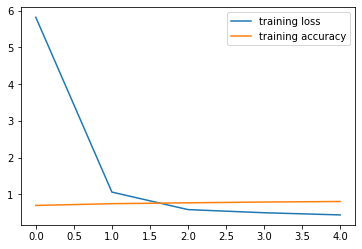

In [145]:
plt.plot(retVal_5.history['loss'], label='training loss')
plt.plot(retVal_5.history['accuracy'], label='training accuracy')
plt.legend()

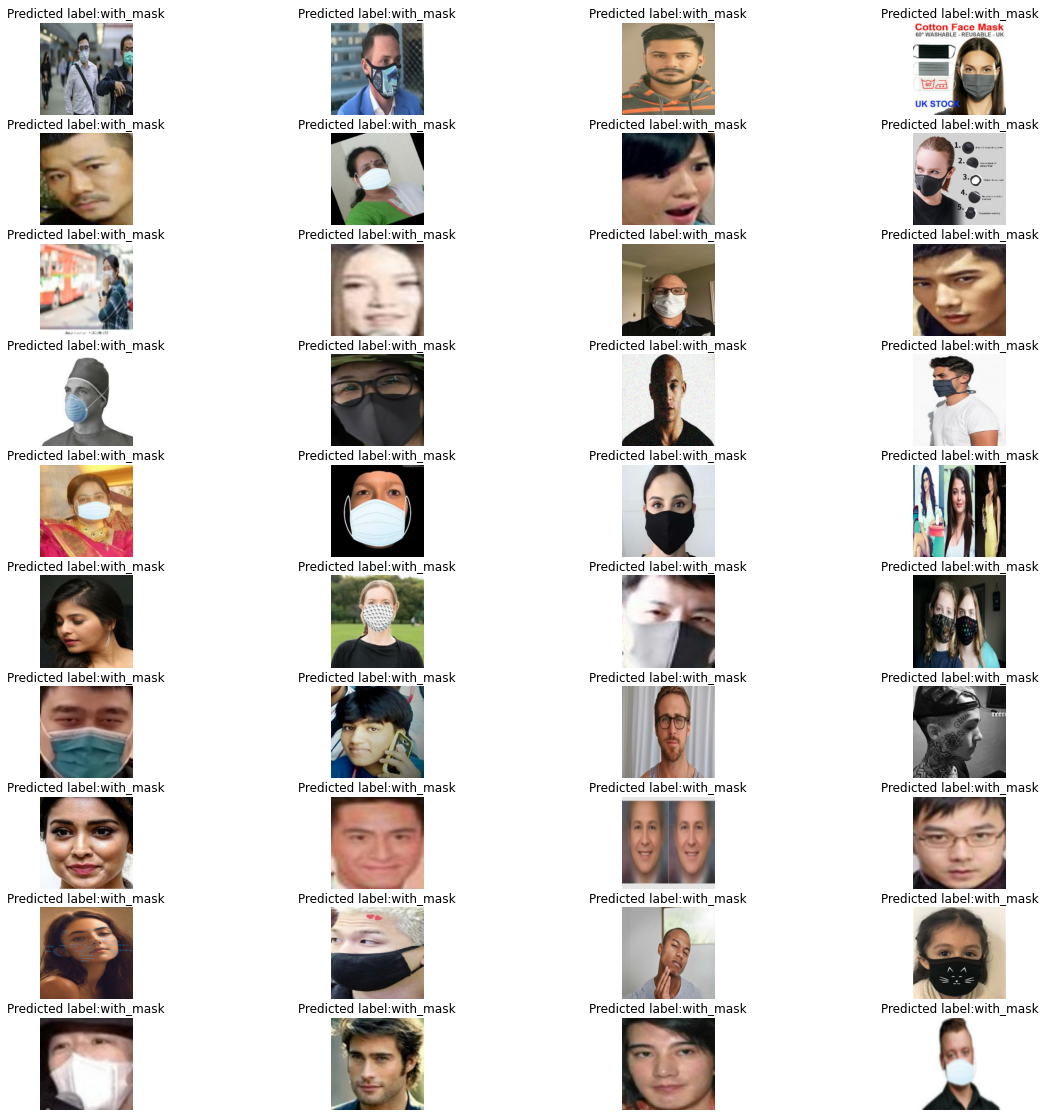

In [146]:
plt.figure(figsize=(20, 20))
for images, labels in test_data.take(1):
    predictions = model_5.predict(images)
    predlabel = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])

    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:' + predlabel[i])
        plt.axis('off')
        plt.grid(True)

In [147]:
scores = model_5.evaluate(test_data, verbose=0)
print(scores[1] * 100)

81.65562748908997


**ResNet50**

In [148]:
ResNet50_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))


trainable=False means that we don't want to teach convolutional part of the model.

In [149]:
ResNet50_model.trainable = False

Let's see all layers and amount of parameters of the vgg16.

In [150]:
ResNet50_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

Let's create model based on ResNet50

In [151]:
model_6 = tf.keras.models.Sequential([
    ResNet50_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')                                
])

In [152]:
model_6.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_12 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 257       
Total params: 19,433,793
Trainable params: 4,719,105
Non-trainable params: 14,714,688
_________________________________________________________________


In terms of ResNet50 had been already trained we need to set a low learing rate for convergence.


In [153]:
model_6.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

Training model. 5 epochs will be enought due to part of the model had been already trained


In [154]:
retVal_6 = model_6.fit(train_data, validation_data=test_data, epochs=5)

Epoch 1/5
152/152 [==============================] - 28s 180ms/step - loss: 3.1325 - accuracy: 0.7270 - val_loss: 0.3129 - val_accuracy: 0.9523
Epoch 2/5
152/152 [==============================] - 28s 182ms/step - loss: 0.6484 - accuracy: 0.9226 - val_loss: 0.1865 - val_accuracy: 0.9715
Epoch 3/5
152/152 [==============================] - 27s 179ms/step - loss: 0.3462 - accuracy: 0.9580 - val_loss: 0.1601 - val_accuracy: 0.9768
Epoch 4/5
152/152 [==============================] - 27s 179ms/step - loss: 0.1862 - accuracy: 0.9724 - val_loss: 0.1258 - val_accuracy: 0.9821
Epoch 5/5
152/152 [==============================] - 27s 180ms/step - loss: 0.1289 - accuracy: 0.9775 - val_loss: 0.1081 - val_accuracy: 0.9834


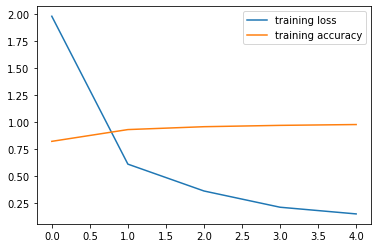

In [155]:
plt.plot(retVal_6.history['loss'], label='training loss')
plt.plot(retVal_6.history['accuracy'], label='training accuracy')
plt.legend()

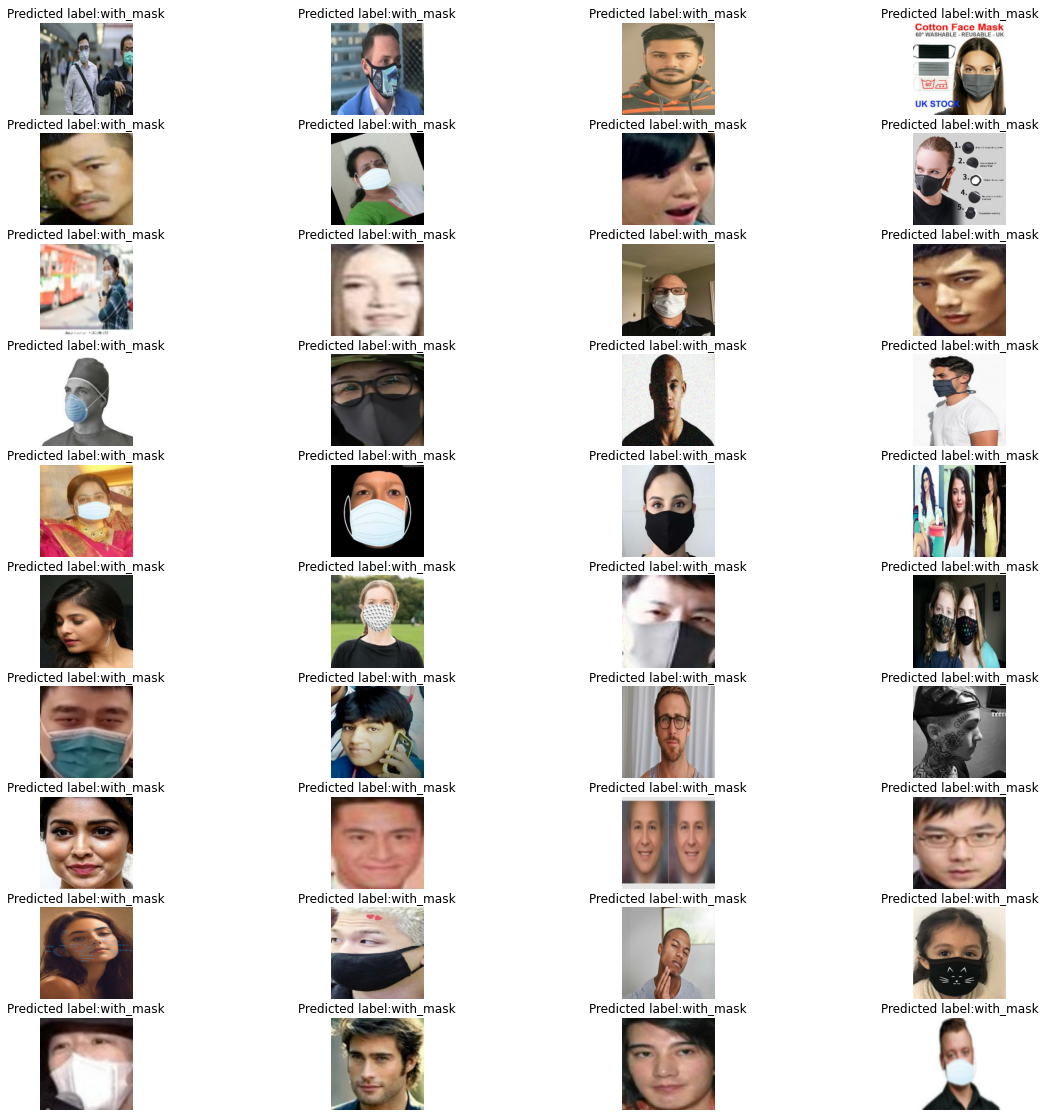

In [156]:
plt.figure(figsize=(20, 20))
for images, labels in test_data.take(1):
    predictions = model_6.predict(images)
    predlabel = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])

    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:' + predlabel[i])
        plt.axis('off')
        plt.grid(True)

In [157]:
scores = model_6.evaluate(test_data, verbose=0)
print(scores[1] * 100)

98.34437370300293


**InceptionV4/InceptionResNet**

In [158]:
InceptionV4_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

In [159]:
InceptionV4_model.trainable = False

In [160]:
InceptionV4_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_411 (Conv2D)             (None, 99, 99, 32)   864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_391 (BatchN (None, 99, 99, 32)   96          conv2d_411[0][0]                 
__________________________________________________________________________________________________
activation_391 (Activation)     (None, 99, 99, 32)   0           batch_normalization_391[0][0]    
________________________________________________________________________________

In [161]:
model_7 = tf.keras.models.Sequential([
    InceptionV4_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')                                
])

In [162]:
model_7.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
flatten_13 (Flatten)         (None, 24576)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               6291712   
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 257       
Total params: 60,628,705
Trainable params: 6,291,969
Non-trainable params: 54,336,736
_________________________________________________________________


In [163]:
model_7.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [164]:
retVal_7 = model_7.fit(train_data, validation_data=test_data, epochs=5)

Epoch 1/5
152/152 [==============================] - 41s 210ms/step - loss: 40.1050 - accuracy: 0.5578 - val_loss: 1.0606 - val_accuracy: 0.5589
Epoch 2/5
152/152 [==============================] - 29s 192ms/step - loss: 1.1629 - accuracy: 0.5897 - val_loss: 0.7121 - val_accuracy: 0.6563
Epoch 3/5
152/152 [==============================] - 29s 191ms/step - loss: 0.7287 - accuracy: 0.6062 - val_loss: 0.6511 - val_accuracy: 0.6623
Epoch 4/5
152/152 [==============================] - 29s 193ms/step - loss: 0.6674 - accuracy: 0.6064 - val_loss: 0.6432 - val_accuracy: 0.6656
Epoch 5/5
152/152 [==============================] - 29s 194ms/step - loss: 0.6530 - accuracy: 0.6076 - val_loss: 0.6261 - val_accuracy: 0.6735


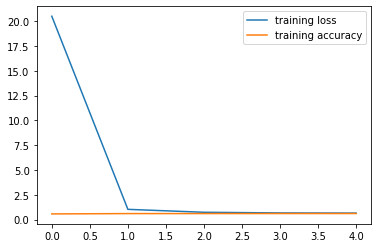

In [165]:
plt.plot(retVal_7.history['loss'], label='training loss')
plt.plot(retVal_7.history['accuracy'], label='training accuracy')
plt.legend()

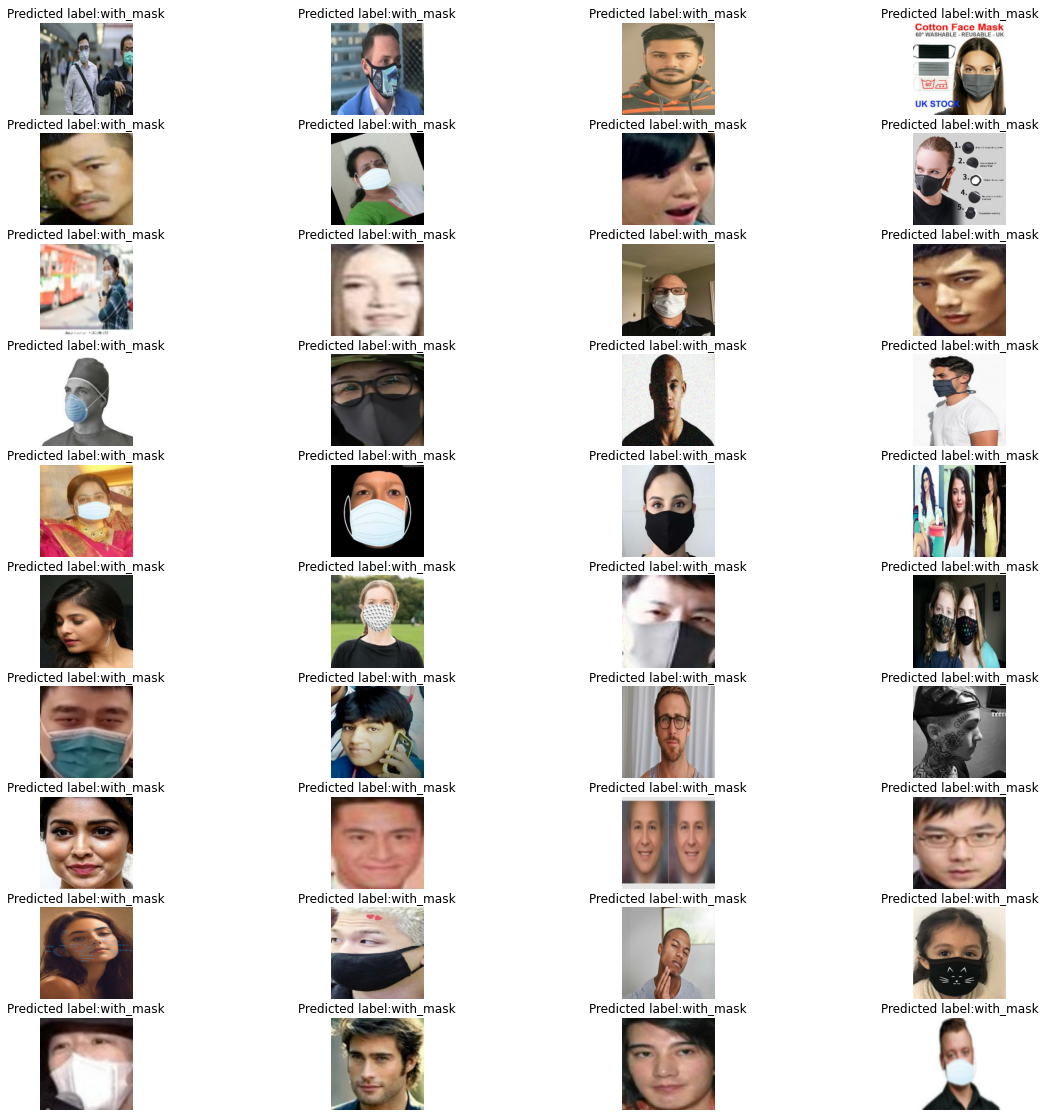

In [166]:
plt.figure(figsize=(20, 20))
for images, labels in test_data.take(1):
    predictions = model_7.predict(images)
    predlabel = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])

    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:' + predlabel[i])
        plt.axis('off')
        plt.grid(True)

In [167]:
scores = model_7.evaluate(test_data, verbose=0)
print(scores[1] * 100)

67.3509955406189


Saving **models**

In [168]:
model.save('maskDetector.h5')
model_1.save('maskDetector_1.h5')
model_2.save('maskDetector_2.h5')
model_3.save('maskDetector_3.h5')
model_4.save('maskDetector_4.h5')
model_5.save('maskDetector_5.h5')
model_6.save('maskDetector_6.h5')
model_7.save('maskDetector_7.h5')